# Kernel Methods and SVMs

First install and import needed packages and libraries

In [2]:
# !pip install numpy scipy pandas matplotlib scikit-learn missingno

In [3]:
import numpy as np
import pandas as pd

We're going to use [Cod-RNA dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#cod-rna) from ([this article](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-173)):

In biology, RNA transports genetic information from DNA to proteins. However, not all RNA and DNA are coding. Other types, such as non-coding RNA, have many other functions.

There are hypotheses suggesting that the secondary structure of genetic material can be used to determine whether RNA is coding. Predicting the higher degree structure of genetic material is a typical machine learning task. As it's expensive to test that experimentally.

The dataset we're going to use for this task has 8 features:
- the value calculated by a [Dynalign](https://www.sciencedirect.com/science/article/abs/pii/S0022283601953513)
- The length of the shortest genetic sequence
- Nucleobase frequencies in sequences 1 and 2 (6 features total)

In [4]:
from sklearn.preprocessing import MinMaxScaler

train_data = pd.read_parquet("cod_rna_train.parquet")
test_data = pd.read_parquet("cod_rna_test.parquet")
y_train, y_test = train_data["y"], test_data["y"]

train_data.head()

,Dynalign,ShorterSeqLength,Seq1FreqA,Seq1FreqU,Seq1FreqC,Seq2FreqA,Seq2FreqU,Seq2FreqC,y
0,-766.0,128.0,0.140625,0.304688,0.234375,0.140625,0.304688,0.234375,-1.0
1,-726.0,131.0,0.129771,0.328244,0.229008,0.129771,0.328244,0.229008,-1.0
2,-648.0,123.0,0.146341,0.333333,0.211382,0.146341,0.333333,0.211382,-1.0
3,-764.0,124.0,0.137097,0.322581,0.233871,0.137097,0.322581,0.233871,-1.0
4,-584.0,130.0,0.153846,0.392308,0.184615,0.153846,0.392308,0.184615,-1.0


<Axes: ylabel='Frequency'>

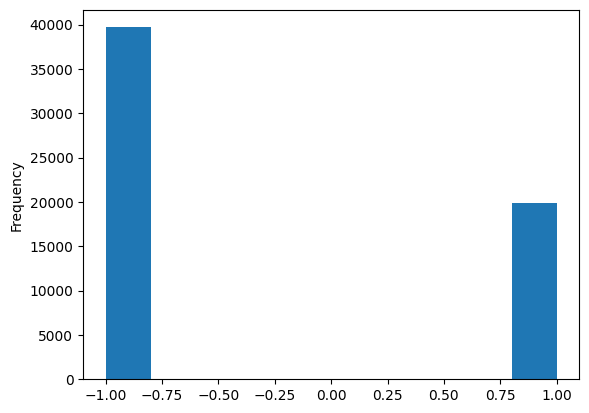

In [9]:
y_train.plot.hist()

We're going to perform a lightly unbalanced binary classification. As a metric we'll use the F1-score

Let's scale the data

In [10]:
scaler = MinMaxScaler((-1, 1))
X_train_scaled = scaler.fit_transform(train_data.drop("y", axis=1))
X_test_scaled = scaler.transform(test_data.drop("y", axis=1))

Let's create a linear regression to use as our baseline for further comparison with SVMs

In [15]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegressionCV

logreg_cv_l2 = LogisticRegressionCV(
    Cs=100, cv=5, scoring="f1", class_weight="balanced", random_state=0, n_jobs=-1
)
logreg_cv_l2.fit(X_train_scaled, y_train)

y_pred = logreg_cv_l2.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")

F1-score: 93.28%


### Typical SVM
Now that our data is prepared let's train a typical support vector machine model
The default loss function for scikit-learn's LinearSVC is squared hinge loss. Let's change that to hinge loss to get a typical SVM

In [12]:
from sklearn.svm import LinearSVC

clf_linear_svc = LinearSVC(loss="hinge", max_iter=10000, random_state=0, dual="auto")
clf_linear_svc.fit(X_train_scaled, y_train)

y_pred = clf_linear_svc.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")

F1-score: 93.03%


We can see that even without hyperparameter tuning we can achieve comparable results

Let's see what we can get with hyperparameter tuning!

In [25]:
from sklearn.model_selection import GridSearchCV

clf = LinearSVC(max_iter=10000, random_state=0, dual="auto")

param_grid = {
    # "C": [0.001, 0.01, 0.1, 1., 10, 100]
    # "C": np.arange(1,100,10)
    "C": np.arange(60, 70, 1),
    "loss": ["hinge", "squared_hinge"],
}

cv = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)

cv.fit(X_train_scaled, y_train)
print("best C", cv.best_params_["C"])
print("optimal loss", cv.best_params_["loss"])

y_pred = cv.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")

best C 64
optimal loss hinge
F1-score: 93.03%


C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


We can see that our scores are not much better than before. However, in the article authors use kernel SVM. Let's see if that can help us improve our scores

Kernel svm is implemented in SVC class. 

In [27]:
from time import time
from sklearn.svm import SVC

clf_kernel_svc = SVC(cache_size=512, class_weight="balanced", random_state=0)

start_training = time()
clf_kernel_svc.fit(X_train_scaled, y_train)
end_training = time()

start_prediction = time()
y_pred = clf_kernel_svc.predict(X_test_scaled)
end_prediction = time()

print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")
print(f"Training time   : {end_training - start_training} s")
print(f"Prediction time : {end_prediction - start_prediction} s")

F1-score: 94.92%
Training time   : 10.117630004882812 s
Prediction time : 86.36837100982666 s


The high time results from the complexity of the kernel SVM - $O(n^2)$ 



In [29]:
start_time = time()
decision_function = clf_kernel_svc.decision_function(X_train_scaled)
end_time = time()
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time} s")

support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]

print("number of support vectors            : ", len(support_vector_indices))
print(
    "support vectors in the training data : ",
    len(support_vector_indices) / X_train_scaled.shape[0],
    "%",
)

Prediction time: 19.03030562400818 s
number of support vectors            :  8449
support vectors in the training data :  0.14191651969429747 %


We can check that the prediction time is much shorter for linear regression and linear SVM

In [31]:
start_time = time()
_ = clf_linear_svc.decision_function(X_train_scaled)
end_time = time()
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time} s")

start_time = time()
_ = logreg_cv_l2.decision_function(X_train_scaled)
end_time = time()

prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time} s")

Prediction time: 0.0019989013671875 s
Prediction time: 0.0009999275207519531 s
